# Split CNN Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Implementation](#implementation)
3. [Evaluation](#evaluation)


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate

In [2]:
# Check TF versions and CPU/GPU availability
print(tf.__version__)
print(tf.config.list_physical_devices())
print(tf.test.is_gpu_available)
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.19.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
<function is_gpu_available at 0x7841bbfe0360>
True
True
Num CPUs Available:  1
Num GPUs Available:  0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pwd
!ls

/content
drive  sample_data


In [5]:
import os
os.chdir("/content/drive/My Drive/Untrained-PINN-for-SIM-main")
print(os.getcwd())

/content/drive/My Drive/Untrained-PINN-for-SIM-main


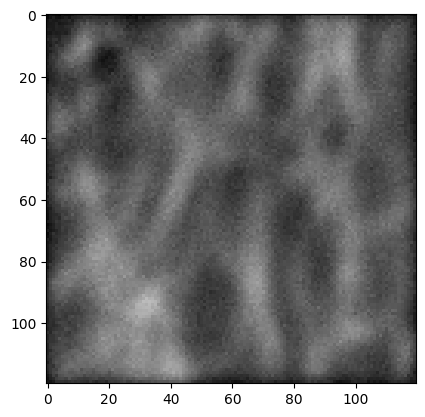

In [6]:
import cv2 #show first picture of folder as image in notebook
img = cv2.imread('Data/LPSIM/microtubules/input_frames/1_1.png')
plt.imshow(img)

## Model Choice

The first baseline CNN model was optimized and split into train and validation  


## Implementation





In [7]:
import numpy as np
import cv2

num_im = 50      # Number of examples in dataset
frames = 24       # Number of sub-frames per example
im_dim = 480     # Image dimension (after super-res)
bg_lvl = 0       # Optional bg level subtraction

input_frames = np.zeros([num_im,im_dim,im_dim,frames])
gt_frames = np.zeros([num_im,im_dim,im_dim,1])
lr_frames = np.zeros([num_im,im_dim,im_dim,1])
patterns = np.zeros([frames,im_dim,im_dim,1])


## Load Data

In [8]:
data_name = 'microtubules'
dir_name = 'Data/LPSIM/'

for i in range(1,num_im):
      
    for j in range(1,(frames+1)):
       
        input_path = dir_name+data_name+'/input_frames/'+str(i)+'_'+str(j)+'.png'
        input_temp = cv2.imread(input_path,0)
        input_temp = cv2.resize(input_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
        input_frames[i-1,:,:,j-1] = input_temp                  
    
    gt_path = dir_name+data_name+'/ground_truth/'+str(i)+'.png'
    gt_temp = cv2.imread(gt_path,0)
    gt_temp = cv2.resize(gt_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
    gt_temp = gt_temp.reshape([im_dim,im_dim,1])
    gt_frames[i-1,:,:,:] = gt_temp

    lr_path = dir_name+data_name+'/low_res/'+str(i)+'.png'
    lr_temp = cv2.imread(lr_path,0)
    lr_temp = cv2.resize(lr_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
    lr_temp = lr_temp.reshape([im_dim,im_dim,1])
    lr_frames[i-1,:,:,:] = lr_temp
    

for i in range(1,(frames+1)):
    
    pattern_path = dir_name+data_name+'/patterns/'+str(i)+'.png'
    pattern_temp = cv2.imread(pattern_path,0)
    pattern = cv2.resize(pattern_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)  
    pattern = pattern.reshape([im_dim,im_dim,1])
    patterns[i-1,:,:,:] = pattern
            

## Check and Normalize Data

In [9]:
print(np.amax(input_frames))
input_frames = input_frames - bg_lvl;
input_frames[input_frames<0] = 0
input_frames = input_frames/np.amax(input_frames)
print(np.amax(input_frames))
gt_fames = gt_frames/np.amax(gt_frames)
lr_frames = lr_frames/np.amax(lr_frames)
patterns = patterns/np.amax(patterns)
print(input_frames.shape)
print(gt_frames.shape)

255.0
1.0
(50, 480, 480, 24)
(50, 480, 480, 1)


Text(0.5, 1.0, 'Illumination pattern')

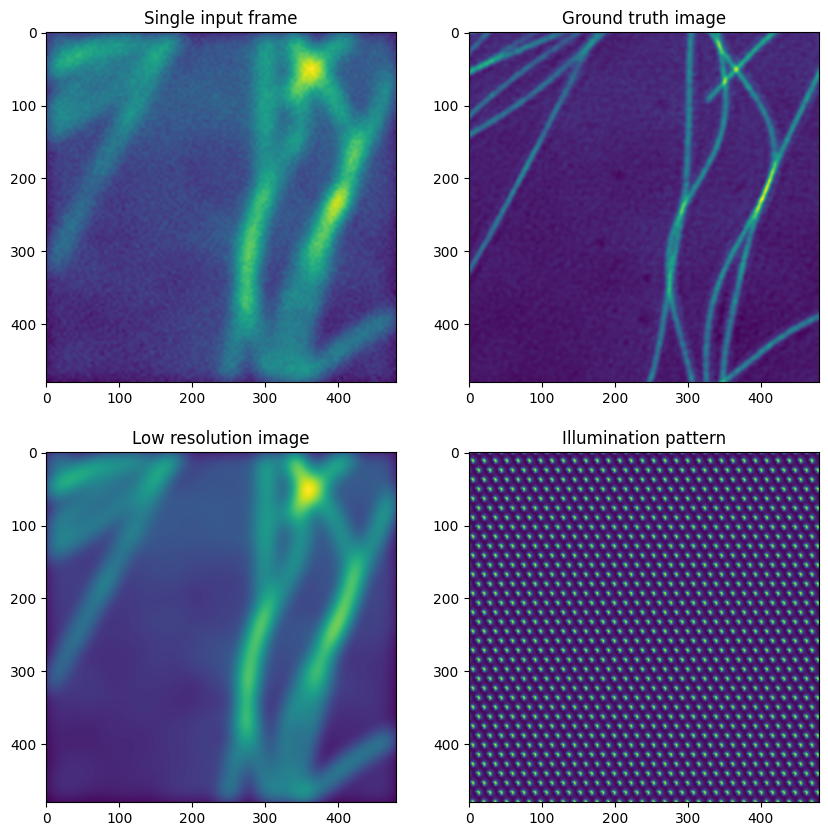

In [10]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(input_frames[1,:,:,1])
plt.title('Single input frame')
plt.subplot(2,2,2)
plt.imshow(gt_frames[1,:,:,:])
plt.title('Ground truth image')
plt.subplot(2,2,3)
plt.imshow(lr_frames[1,:,:,:])
plt.title('Low resolution image')
plt.subplot(2,2,4)
plt.imshow(patterns[1,:,:,:])
plt.title('Illumination pattern')

## Define Model

In [17]:
x_baseline= np.reshape(lr_frames,[num_im,im_dim,im_dim,1])
y_baseline= np.reshape(gt_frames,[num_im,im_dim,im_dim,1])

print(x_baseline.shape)
print(y_baseline.shape)


# Compile and train the baseline model

mse_loss = tf.keras.losses.MeanSquaredError()

eps = 10

(50, 480, 480, 1)
(50, 480, 480, 1)


In [18]:

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_baseline, y_baseline, test_size=0.2, random_state=42)

print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_val: {x_val.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")

Shape of x_train: (40, 480, 480, 1)
Shape of x_val: (10, 480, 480, 1)
Shape of y_train: (40, 480, 480, 1)
Shape of y_val: (10, 480, 480, 1)


In [19]:
# Implement callback 

from tensorflow.keras.callbacks import EarlyStopping

# Create an EarlyStopping callback instance
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True
)

print("EarlyStopping callback defined.")

EarlyStopping callback defined.


In [20]:
from tensorflow.keras.layers import Dropout

def baseline_model_with_dropout():
    # Input layer with shape (im_dim, im_dim, 1) for low-resolution images
    inputs = Input(shape=(im_dim, im_dim, 1))

    # Encoder part / feature extraction layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Dropout(0.25)(x) # Added Dropout
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.25)(x) # Added Dropout

    # Decoder part / reconstruction layers
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.25)(x) # Added Dropout
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.25)(x) # Added Dropout

    # Output layer: 1 filter for a single channel output image
    outputs = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the baseline model with dropout
baseline_cnn_model = baseline_model_with_dropout()

# Print the model summary
print("Baseline CNN Model with Dropout Architecture:")
baseline_cnn_model.summary()

Baseline CNN Model with Dropout Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 480, 480, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 480, 480, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 480, 480, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 480, 480, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 480, 480, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 480, 480, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 480, 480, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 480, 480, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 480, 480, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 480, 480, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
new_learning_rate = 0.001 

# Define the new loss function and optimizer

new_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    new_learning_rate,
    decay_steps=100, # Adjusted decay steps
    decay_rate=0.95, # Adjusted decay rate for slower decay
    staircase=True)

opt_baseline_tuned = tf.keras.optimizers.Adam(new_lr_schedule)

# Compile the baseline model with the new optimizer
baseline_cnn_model.compile(loss=mse_loss, optimizer=opt_baseline_tuned)

print("Baseline CNN model recompiled with tuned learning rate schedule.")

Baseline CNN model recompiled with tuned learning rate schedule.


In [23]:
print("Starting baseline CNN model training with optimizations...")

batch_size = 8 # Adjusted batch size 

baseline_model_history_optimized = baseline_cnn_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=eps, # Use the previously defined number of epochs
    validation_data=(x_val, y_val),
    callbacks=[early_stopping_callback], # Add the EarlyStopping callback
    shuffle=True
)

print("Baseline CNN model training with optimizations finished.")

Starting baseline CNN model training with optimizations...
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 192s 38s/step - loss: 2544.5862 - val_loss: 2405.5496
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 185s 37s/step - loss: 2354.9539 - val_loss: 1763.7406
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 214s 40s/step - loss: 1496.1997 - val_loss: 556.0966
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 190s 37s/step - loss: 810.4516 - val_loss: 561.4175
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 204s 38s/step - loss: 603.3573 - val_loss: 684.8215
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 192s 39s/step - loss: 709.3840 - val_loss: 551.2211
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 196s 40s/step - loss: 585.6777 - val_loss: 592.4064
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 192s 38s/step - loss: 605.5047 - val_loss: 516.6379
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 187s 38s/step - loss: 568.6519 - val_loss: 558.7968
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 201s 38s/step - loss: 595.2150 - val_loss: 515.1459
Baseline CNN model training with optimizations finished

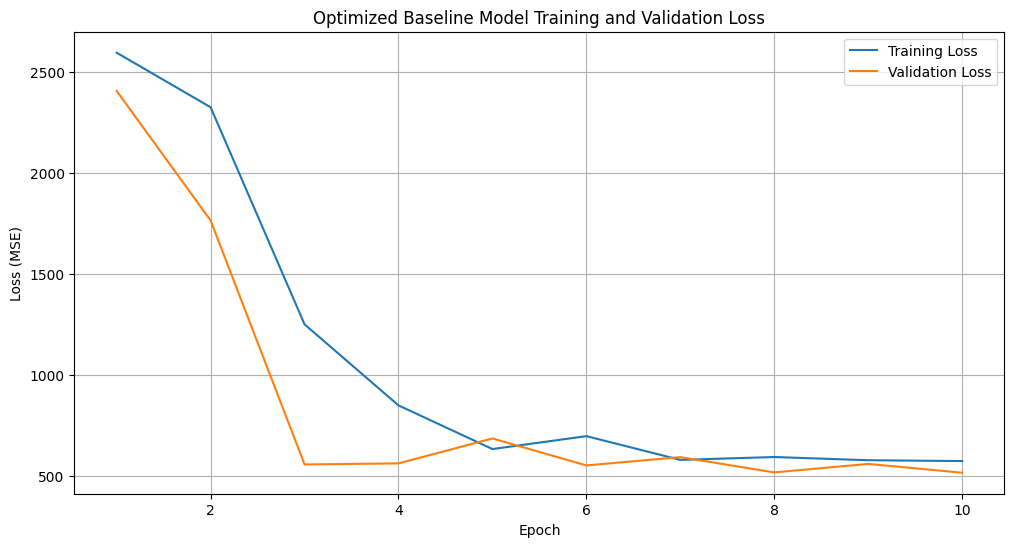

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Plot loss curves
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(1, len(baseline_model_history_optimized.history['loss']), num=len(baseline_model_history_optimized.history['loss'])), baseline_model_history_optimized.history['loss'], label='Training Loss')
plt.plot(np.linspace(1, len(baseline_model_history_optimized.history['val_loss']), num=len(baseline_model_history_optimized.history['val_loss'])), baseline_model_history_optimized.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.title('Optimized Baseline Model Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

A visual comparison of the original and ground truth images with the predicted images



1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


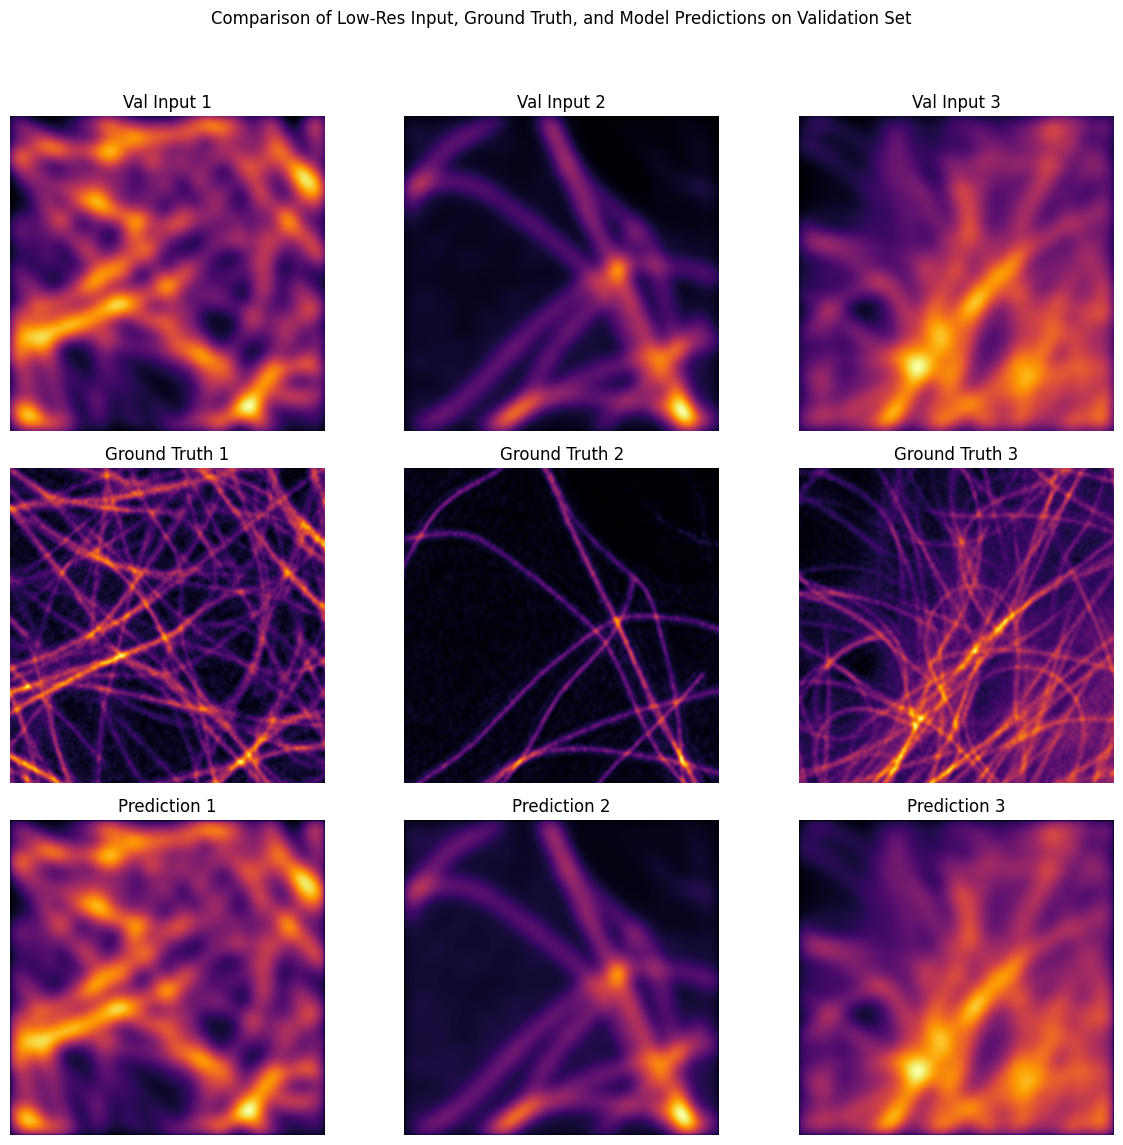

In [25]:
#Evaluatiuon of predicted images of baseline model

num_examples_to_show = 3 # Number of examples to visualize

# Generate predictions on the validation set
predictions = baseline_cnn_model.predict(x_val)

# Visualize predictions for a few examples
plt.figure(figsize=(num_examples_to_show * 4, 12))
for i in range(num_examples_to_show):
    # Original Low-Resolution Input
    plt.subplot(3, num_examples_to_show, i + 1)
    plt.imshow(x_val[i, :, :, 0], cmap='inferno')
    plt.title(f'Val Input {i+1}')
    plt.axis('off')

    # Ground Truth
    plt.subplot(3, num_examples_to_show, i + 1 + num_examples_to_show)
    plt.imshow(y_val[i, :, :, 0], cmap='inferno')
    plt.title(f'Ground Truth {i+1}')
    plt.axis('off')

    # Model Prediction
    plt.subplot(3, num_examples_to_show, i + 1 + 2 * num_examples_to_show)
    plt.imshow(predictions[i, :, :, 0], cmap='inferno')
    plt.title(f'Prediction {i+1}')
    plt.axis('off')

plt.suptitle('Comparison of Low-Res Input, Ground Truth, and Model Predictions on Validation Set')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
plt.show()